#Viral Tweets 

In this project, we are going to use the K-Nearest Neighbor (KNN) machine learning algorithm to predict whether a tweet will go viral. Below are the sections of the project for better navigation:


1. Libraries
2. Inspection of the dataset
3. Creating features and labels
4. Normalizing the data
5. Spliting Train and Test Set
6. Training the Classifier
7. Fine tuning the parameter 'k'
8. Defining best prediction ratio (score)


##Libraries

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

## Inspection of the dataset


First lets take a look on the dataset to get some insights and inspect the data.

In [42]:
### Importing the json file from my github repository into a pandas DataFrame object ###
all_tweets = pd.read_json("https://raw.githubusercontent.com/Joaoluislins/Twitter_classification/main/random_tweets.json", lines=True)
print(all_tweets.info())
all_tweets.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11099 entries, 0 to 11098
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   created_at                 11099 non-null  datetime64[ns, UTC]
 1   id                         11099 non-null  int64              
 2   id_str                     11099 non-null  int64              
 3   text                       11099 non-null  object             
 4   truncated                  11099 non-null  bool               
 5   entities                   11099 non-null  object             
 6   metadata                   11099 non-null  object             
 7   source                     11099 non-null  object             
 8   in_reply_to_status_id      1402 non-null   float64            
 9   in_reply_to_status_id_str  1402 non-null   float64            
 10  in_reply_to_user_id        1503 non-null   float64            
 11  in

,created_at,id,id_str,text,truncated,entities,metadata,source,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,in_reply_to_screen_name,user,geo,coordinates,place,contributors,retweeted_status,is_quote_status,retweet_count,favorite_count,favorited,retweeted,lang,possibly_sensitive,quoted_status_id,quoted_status_id_str,extended_entities,quoted_status,withheld_in_countries
0,2018-07-31 13:34:40+00:00,1024287229525598210,1024287229525598208,RT @KWWLStormTrack7: We are more than a month ...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",NaN,NaN,NaN,NaN,None,"{'id': 145388018, 'id_str': '145388018', 'name...",None,None,None,NaN,{'created_at': 'Mon Jul 30 16:49:41 +0000 2018...,False,3,0,False,False,en,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-07-31 13:34:40+00:00,1024287229512953856,1024287229512953856,@hail_ee23 Thanks love its just the feeling of...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",1.024128e+18,1.024128e+18,9.271857e+17,9.271857e+17,hail_ee23,"{'id': 2407992339, 'id_str': '2407992339', 'na...",None,None,"{'id': '26b41b13d49ea2bf', 'url': 'https://api...",NaN,NaN,False,0,0,False,False,en,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-07-31 13:34:40+00:00,1024287229504569344,1024287229504569344,RT @TransMediaWatch: Pink News has more on the...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,NaN,NaN,None,"{'id': 901579698223931392, 'id_str': '90157969...",None,None,None,NaN,{'created_at': 'Tue Jul 31 11:03:32 +0000 2018...,False,5,0,False,False,en,0.0,NaN,NaN,NaN,NaN,NaN
3,2018-07-31 13:34:40+00:00,1024287229496029190,1024287229496029184,RT @realDonaldTrump: One of the reasons we nee...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",NaN,NaN,NaN,NaN,None,"{'id': 23438548, 'id_str': '23438548', 'name':...",None,None,None,NaN,{'created_at': 'Tue Jul 31 11:00:41 +0000 2018...,False,11106,0,False,False,en,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-07-31 13:34:40+00:00,1024287229492031490,1024287229492031488,RT @First5App: This hearing of His Word doesn’...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,NaN,NaN,None,"{'id': 942424782, 'id_str': '942424782', 'name...",None,None,None,NaN,{'created_at': 'Tue Jul 31 12:30:05 +0000 2018...,False,6,0,False,False,en,NaN,NaN,NaN,NaN,NaN,NaN


Wow, its a huge amount of info! there are 11099 rows and 31 columns in total, and some values, such as the in the user column, are dictionaries themselves with a lot more content!

Which atributtes should I consider as features to our KNN model as the ones that most influences the chances of a tweet going viral?

*   Number of user's followers
*   Number of user's friends
*   Language used
*   Tweet length
*   Number of hashtags
*   Number of links
*   The number of words
*   The average length of the words




# Creating features and labels

A K-Nearest Neighbor classifier is a supervised machine learning algorithm, and as a result, we need to have a dataset with tagged labels. For this specific example, we need a dataset where every tweet is marked as viral or not viral.

So how do we define a viral tweet?
A good place to start is to look at the number of retweets the tweet has. 


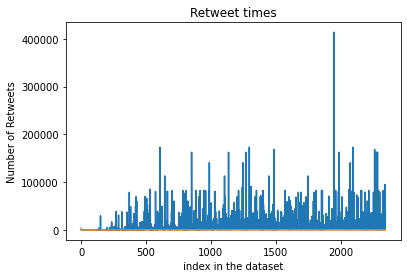

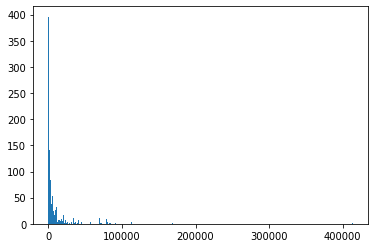

5584     413719
6185     173062
6454     173061
9271     173061
4821     173060
6174     168485
4550     168484
8460     162433
7198     162431
4889     162428
3311     162425
3741     162425
1599     162423
1667     162421
7        162420
3094     162417
9186     140541
7529     140539
1297     140538
10381    112879
10395    112879
9895     112878
4694     112875
1504     112869
5766      94965
5396      91076
9764      89348
9311      85216
10515     85216
9567      84130
646       82765
10329     82600
9808      82595
9459      82591
8997      82587
8509      82586
8626      82586
8108      82583
7839      82581
7581      82578
7454      82576
7486      82576
6323      82562
6026      82560
6038      82560
5535      82558
5207      82551
3952      82543
3968      82543
3779      82541
Name: retweet_count, dtype: int64
2777.95639246779


In [38]:
### Analyzing the popularity of each sample in the dataset ###
ret_count = all_tweets['retweet_count'].value_counts().reset_index().rename(columns = {'index': 'Retweet_times', 'retweet_count': 'Frequency'})
plt.plot(range(len(ret_count)), ret_count)
plt.title('Retweet times')
plt.xlabel('index in the dataset')
plt.ylabel('Number of Retweets')
plt.show()

### Analyzing the distribution of popularity ###
plt.hist(ret_count['Retweet_times'], bins = 1000)
plt.show()

print(all_tweets['retweet_count'].nlargest(50))
print(all_tweets['retweet_count'].mean())



It seems that although there are tweets with outstanding popularity, they are extremely rare, as the distribution graph and low mean shows..

To define what a viral tweet label is, I'm going to first use the median and then experiment with the third quartile to see if my model's accuracy changes substancially.

In [ ]:
print(all_tweets['user'][0])
features['avg_length_words'] =  all_tweets.apply(lambda tweet: (len(tweet['text']) / tweet['n_words']), axis = 1)


In [58]:
ret_median = all_tweets['retweet_count'].median()
labels = np.where(all_tweets['retweet_count'] > ret_median, 1, 0)

features = pd.DataFrame()
features['retweet_counts'] = all_tweets['retweet_count']
features['n_user_followers'] = all_tweets.apply(lambda tweet: tweet['user']['followers_count'], axis = 1)
features['n_user_friends'] = all_tweets.apply(lambda tweet: tweet['user']['friends_count'], axis = 1)
features['language'] = all_tweets.apply(lambda tweet: tweet['user']['lang'], axis = 1)
features['tweet_length'] = all_tweets.apply(lambda tweet: len(tweet['text']), axis = 1)
features['n_hash'] = all_tweets.apply(lambda tweet: tweet['text'].count('#'), axis = 1)
features['n_links'] = all_tweets.apply(lambda tweet: tweet['text'].count('http'), axis = 1)
features['n_words'] = all_tweets.apply(lambda tweet: len(tweet['text'].split(' ')), axis = 1)
features['avg_length_words'] = features.apply(lambda row: (row['tweet_length'] / row['n_words']), axis = 1)


,retweet_counts,n_user_followers,n_user_friends,language,tweet_length,n_hash,n_links,n_words,avg_length_words
0,3,215,335,en,140,0,0,26,5.384615
1,0,199,203,en,77,0,0,15,5.133333
2,5,196,558,en,140,0,0,22,6.363636
3,11106,3313,2272,en,140,0,0,24,5.833333
4,6,125,273,en,140,0,0,24,5.833333


In [ ]:
all_tweets['tweet_length'] = all_tweets.apply(lambda tweet: len(tweet['text']), axis=1)

# Normalizing The Data

We've now made the features/labels that we want to feed into our classifier. But first, as the features are in distinct magnitudes, let's scale the data.


The scale function will normalize the data so all of the features will vary within the same range. (axis = 0 scales feature-wise (columns))

# Creating the Training Set and Test Set

To evaluate the effectiveness of our classifier, we now split `scaled_data` and `labels` into a training set and test set using scikit-learn's `train_test_split` function. This function takes two required parameters: It takes the data, followed by the labels. Set the optional parameter `test_size` to be `0.2`. You can also set the `random_state` parameter so your code will randomly split the data in the same way as our solution code splits the data. We used `random_state = 1`. Remember, this function returns 4 items in this order:

1. The training data
2. The testing data
3. The training labels
4. The testing labels

Store the results in variables named `train_data`, `test_data`, `train_labels`, and `test_labels`.

# Using the Classifier

We can finally use the K-Nearest Neighbor classifier. Let's test it using `k = 5`. Begin by creating a `KNeighborsClassifier` object named `classifier` with the parameter `n_neighbors` equal to `5`.

Next, train `classifier` by calling the `.fit()` method with `train_data` and `train_labels` as parameters.

Finally, let's test the model! Call `classifier`'s `.score()` method using `test_data` and `test_labels` as parameters. Print the results.


# Choosing K

We've tested our classifier with `k = 5`, but maybe there's a `k` that will work better. Let's test many different values for `k` and graph the results. 

First, create an empty list called `scores`. Next, create a for loop that has a variable `k` that begins at `1` and ends at `200`.

Inside the for loop, create a `KNeighobrsClassifier` object named `classifier` with the parameter `n_neighbors` equal to `k`.

Train `classifier` by calling the `.fit()` method with `train_data` and `train_labels` as parameters.

Next, let's test the model! Call `classifier`'s `.score()` method using `test_data` and `test_labels` as parameters. `append` the result to `scores`.

Finally, let's plot the results. Outside of the loop, use Matplotlib's `plot()` function. `plot()` takes two parameters &mdash; the data on the x-axis and the data on the y-axis. Data on the x-axis should be the values we used for `k`. In this case, `range(1,200)`.  Data on the y-axis should be `scores`. Make sure to call the `plt.show()` function after calling `plt.plot()`. This should take a couple of seconds to run!

# Explore on your own

Nice work! You can see the classifier gets better as `k` increases, but as `k` gets too high, underfitting starts to happen.

By using the features `tweet_length`, `followers_count`, and `friends_count`, we were able to get up to around 63% accuracy. That is better than random, but still not exceptional. Can you find some different features that perform better? Share your graphs with us on Twitter and maybe it will go viral!